# Credit Risk Classification

Credit risk poses a classification problem that’s inherently imbalanced. This is because healthy loans easily outnumber risky loans. In this Challenge, you’ll use various techniques to train and evaluate models with imbalanced classes. You’ll use a dataset of historical lending activity from a peer-to-peer lending services company to build a model that can identify the creditworthiness of borrowers.

## Instructions:

This challenge consists of the following subsections:

* Split the Data into Training and Testing Sets

* Create a Logistic Regression Model with the Original Data

* Predict a Logistic Regression Model with Resampled Training Data 

### Split the Data into Training and Testing Sets

Open the starter code notebook and then use it to complete the following steps.

1. Read the `lending_data.csv` data from the `Resources` folder into a Pandas DataFrame.

2. Create the labels set (`y`)  from the “loan_status” column, and then create the features (`X`) DataFrame from the remaining columns.

    > **Note** A value of `0` in the “loan_status” column means that the loan is healthy. A value of `1` means that the loan has a high risk of defaulting.  

3. Check the balance of the labels variable (`y`) by using the `value_counts` function.

4. Split the data into training and testing datasets by using `train_test_split`.

### Create a Logistic Regression Model with the Original Data

Employ your knowledge of logistic regression to complete the following steps:

1. Fit a logistic regression model by using the training data (`X_train` and `y_train`).

2. Save the predictions on the testing data labels by using the testing feature data (`X_test`) and the fitted model.

3. Evaluate the model’s performance by doing the following:

    * Calculate the accuracy score of the model.

    * Generate a confusion matrix.

    * Print the classification report.

4. Answer the following question: How well does the logistic regression model predict both the `0` (healthy loan) and `1` (high-risk loan) labels?

### Predict a Logistic Regression Model with Resampled Training Data

Did you notice the small number of high-risk loan labels? Perhaps, a model that uses resampled data will perform better. You’ll thus resample the training data and then reevaluate the model. Specifically, you’ll use `RandomOverSampler`.

To do so, complete the following steps:

1. Use the `RandomOverSampler` module from the imbalanced-learn library to resample the data. Be sure to confirm that the labels have an equal number of data points. 

2. Use the `LogisticRegression` classifier and the resampled data to fit the model and make predictions.

3. Evaluate the model’s performance by doing the following:

    * Calculate the accuracy score of the model.

    * Generate a confusion matrix.

    * Print the classification report.
    
4. Answer the following question: How well does the logistic regression model, fit with oversampled data, predict both the `0` (healthy loan) and `1` (high-risk loan) labels?

### Write a Credit Risk Analysis Report

For this section, you’ll write a brief report that includes a summary and an analysis of the performance of both machine learning models that you used in this challenge. You should write this report as the `README.md` file included in your GitHub repository.

Structure your report by using the report template that `Starter_Code.zip` includes, and make sure that it contains the following:

1. An overview of the analysis: Explain the purpose of this analysis.


2. The results: Using bulleted lists, describe the balanced accuracy scores and the precision and recall scores of both machine learning models.

3. A summary: Summarize the results from the machine learning models. Compare the two versions of the dataset predictions. Include your recommendation for the model to use, if any, on the original vs. the resampled data. If you don’t recommend either model, justify your reasoning.

In [1]:
# Import the modules
import numpy as np
import pandas as pd
import xgboost as xgb
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

---

## Split the Data into Training and Testing Sets

### Step 1: Read the `lending_data.csv` data from the `Resources` folder into a Pandas DataFrame.

In [2]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
test_loan_df = pd.read_csv(Path("Resources/test-loan defaulter data.csv"))

# Review the DataFrame
test_loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
test_loan_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Step 2: Create the labels set (`y`)  from the “loan_status” column, and then create the features (`X`) DataFrame from the remaining columns.

In [4]:
test_loan_df.shape

(614, 13)

In [5]:
test_loan_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [6]:
test_loan_df['Property_Area'].value_counts()

Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64

In [7]:
test_loan_df['Credit_History'].value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

In [8]:
test_loan_df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
# fill the missing values for numerical terms - mean
test_loan_df['LoanAmount'] = test_loan_df['LoanAmount'].fillna(test_loan_df['LoanAmount'].mean())
test_loan_df['Loan_Amount_Term'] = test_loan_df['Loan_Amount_Term'].fillna(test_loan_df['Loan_Amount_Term'].mean())
test_loan_df['Credit_History'] = test_loan_df['Credit_History'].fillna(test_loan_df['Credit_History'].mean())

In [10]:
# fill the missing values for categorical terms - mode
test_loan_df['Gender'] = test_loan_df["Gender"].fillna(test_loan_df['Gender'].mode()[0])
test_loan_df['Married'] = test_loan_df["Married"].fillna(test_loan_df['Married'].mode()[0])
test_loan_df['Dependents'] = test_loan_df["Dependents"].fillna(test_loan_df['Dependents'].mode()[0])
test_loan_df['Self_Employed'] = test_loan_df["Self_Employed"].fillna(test_loan_df['Self_Employed'].mode()[0])

In [11]:
test_loan_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [12]:
test_loan_df.duplicated().sum()

0

In [13]:
test_loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## Exploratory Data Analysis

<Axes: xlabel='Gender', ylabel='count'>

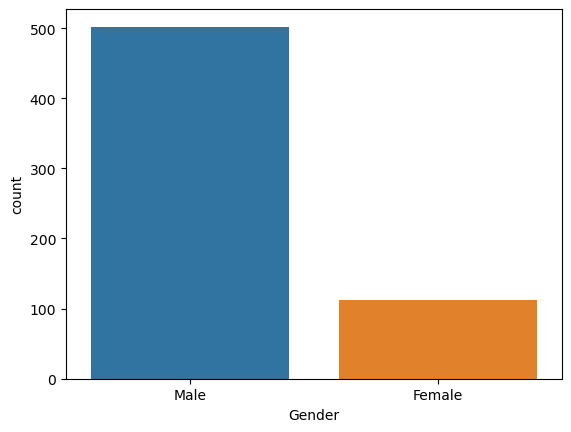

In [14]:
# categorical attributes visualization
sns.countplot(x ='Gender', data = test_loan_df)

<Axes: xlabel='Married', ylabel='count'>

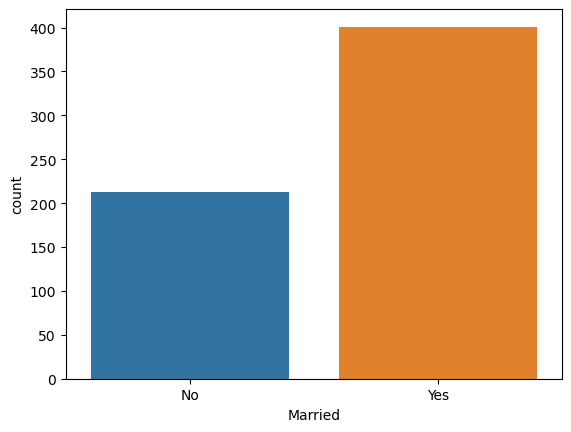

In [15]:
sns.countplot(x ='Married', data = test_loan_df)

<Axes: xlabel='Dependents', ylabel='count'>

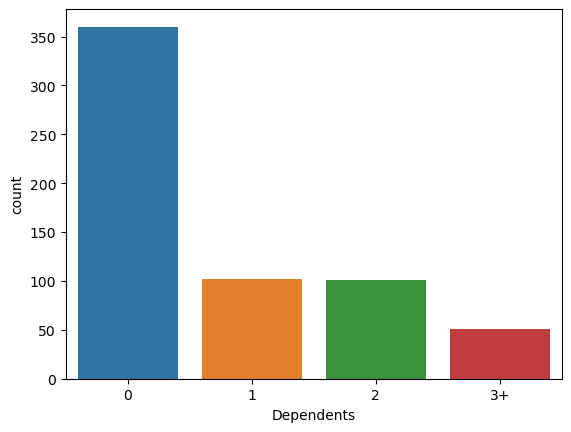

In [16]:
sns.countplot(x ='Dependents', data = test_loan_df)

<Axes: xlabel='Education', ylabel='count'>

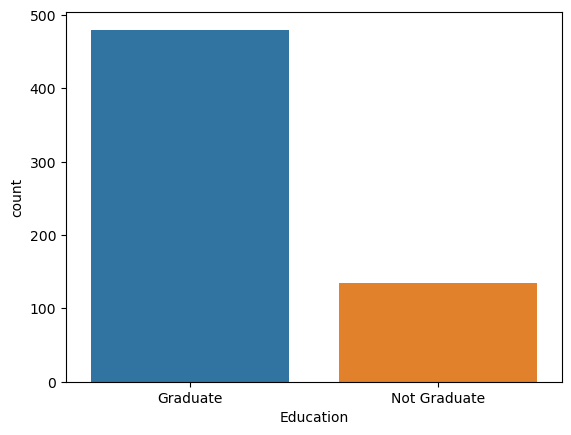

In [17]:
sns.countplot(x ='Education', data = test_loan_df)

<Axes: xlabel='Self_Employed', ylabel='count'>

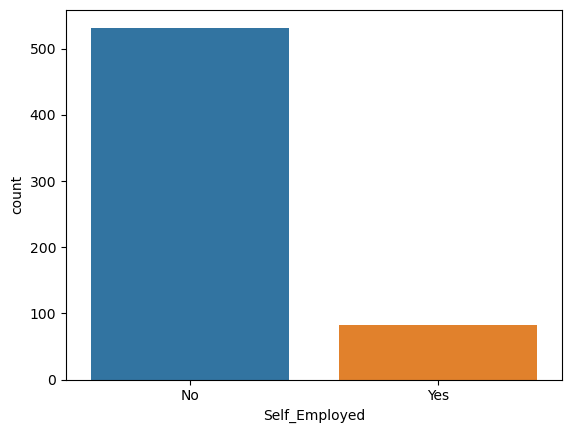

In [18]:
sns.countplot(x ='Self_Employed', data = test_loan_df)

<Axes: xlabel='Property_Area', ylabel='count'>

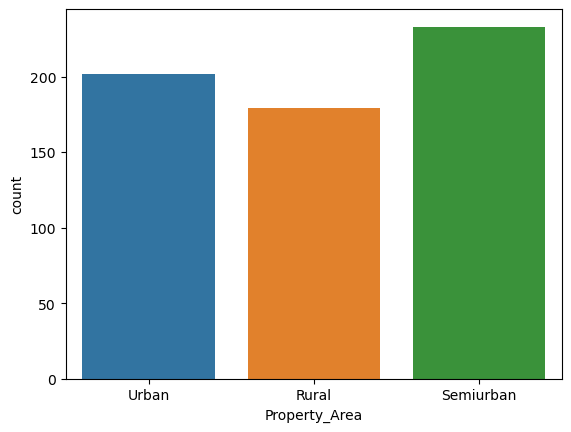

In [19]:
sns.countplot(x ='Property_Area', data = test_loan_df)

<Axes: xlabel='Loan_Status', ylabel='count'>

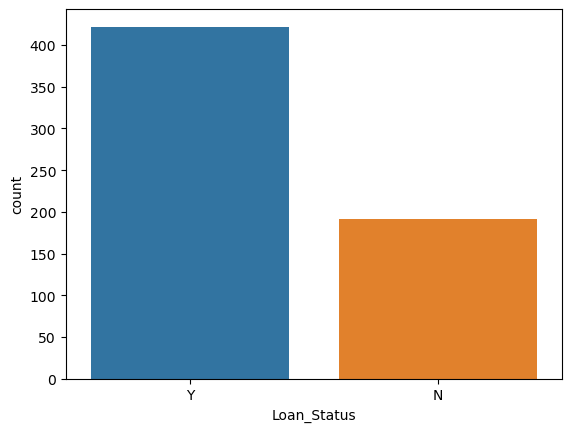

In [20]:
sns.countplot(x ='Loan_Status', data = test_loan_df)

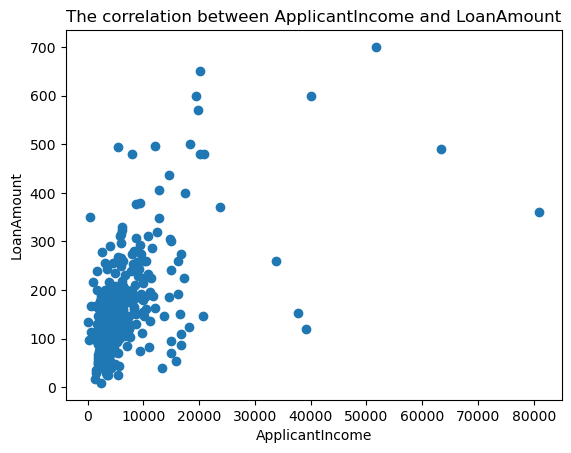

In [21]:
# correlation between applicant income and Loan amount
 
plt.scatter(x='ApplicantIncome',y='LoanAmount',data=test_loan_df)
plt.xlabel('ApplicantIncome')
plt.ylabel('LoanAmount')
plt.title('The correlation between ApplicantIncome and LoanAmount')
plt.show()

## Creation of new attributes

In [22]:
# total income
test_loan_df['Total_Income'] = test_loan_df['ApplicantIncome'] + test_loan_df['CoapplicantIncome']
test_loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0


## Label Encoding

In [23]:
# Label Encode The Target Variable
encode = LabelEncoder()
test_loan_df.Loan_Status = encode.fit_transform(test_loan_df.Loan_Status)

In [24]:
# Ordinal Encode The features
enc = OrdinalEncoder() 
test_loan_df[["Gender",'Married','Education','Self_Employed','Property_Area','Loan_Status', 'Dependents']] = enc.fit_transform(test_loan_df[["Gender",'Married','Education','Self_Employed','Property_Area','Loan_Status', 'Dependents']])
test_loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1.0,5849.0
1,LP001003,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0.0,6091.0
2,LP001005,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1.0,3000.0
3,LP001006,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1.0,4941.0
4,LP001008,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1.0,6000.0


The dataset's values are all now presented as numbers. It will make training our model easier for us.
For Loan status 1 indicates 'Yes'or 'Approved' and 0 indicates 'No' or 'Rejected'.

## Splitting it into dependence and independence variables (Target and Features)

In [25]:
# specify input and output attributes
X = test_loan_df.drop(columns=['Loan_ID','Loan_Status'], axis=1)
y = test_loan_df['Loan_Status']

In [26]:
# Review the y variable Series
y[:5]

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: Loan_Status, dtype: float64

## Checking the balance of the labels variable (y) by using the value_counts function.

In [27]:
# Check the balance of our target values
y.value_counts()

Loan_Status
1.0    422
0.0    192
Name: count, dtype: int64

## Split the data into training and testing datasets by using train_test_split.

In [28]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [29]:
def classification_metrics(y_true, y_pred, class_labels=None):
    """
    Display the classification report and confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        class_labels (list, optional): List of class labels for display. If not provided, it will be inferred.

    Returns:
        None
    """
    if class_labels is None:
        class_labels = sorted(set(y_true))  # Infer class labels from y_true

    # Map binary labels to meaningful labels
    class_labels = ["Loan Repaid", "Defaulted on Loan"]

    # Print the classification report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("Classification Report:\n", report)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=class_labels, yticklabels=class_labels)
    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    
    plt.show()

In [30]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier

    predictors: independent variables

    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    precision = round(precision_score(target, pred, average='macro'), 2)     # Precision score
    recall = round(recall_score(target, pred, average='macro'), 2)           # Recall score
    accuracy = round(accuracy_score(target, pred), 2)                        # Accuracy score

    # Creating a dictionary of metrics
    metrics_dict = {
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
    }

    return metrics_dict

In [31]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state = 1)

# Fit the model using training data
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(random_state=1)

# Create a Logistic Regression Model with the Original Data

## Make a prediction using the training data

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.92      0.45      0.61       143
Defaulted on Loan       0.80      0.98      0.88       317

         accuracy                           0.82       460
        macro avg       0.86      0.72      0.74       460
     weighted avg       0.84      0.82      0.80       460



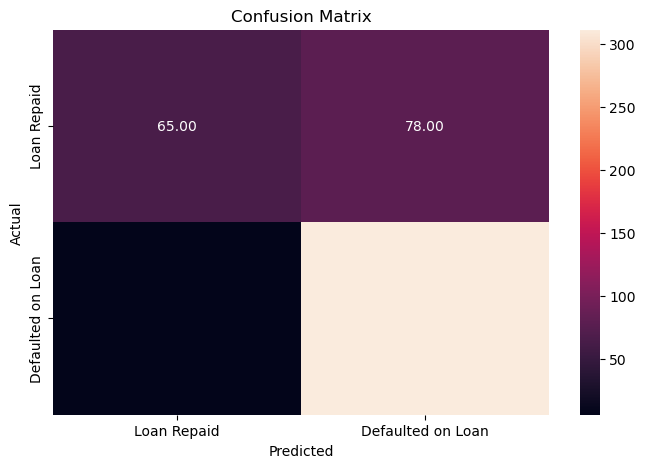

In [32]:
# Create a Logistic Regression model
logistic_model = LogisticRegression(random_state=1)

# Fit the model on the training data
logistic_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred_log_reg = logistic_model.predict(X_train)

# Evaluate the performance on the training set
classification_metrics(y_train, y_train_pred_log_reg)

These measures imply that the model does a good job of categorizing "Loan Repaid" occurrences but has trouble locating "Defaulted on Loan" examples (poor recall). To improve the model's performance on the "Defaulted on Loan" class, addressing issues with class imbalance may be required.

## Make a prediction using the testing data

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.86      0.39      0.54        49
Defaulted on Loan       0.77      0.97      0.86       105

         accuracy                           0.79       154
        macro avg       0.82      0.68      0.70       154
     weighted avg       0.80      0.79      0.76       154



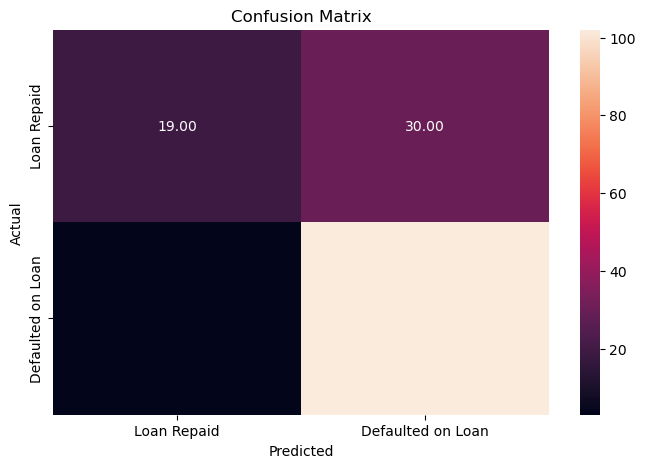

In [33]:
# Predict on the test set
y_prediction = logistic_model.predict(X_test)

# Evaluate the performance on the test set
classification_metrics(y_test,y_prediction)

When testing the logistic regression model, "Loan Repaid" cases are well-predicted, but "Defaulted on Loan" examples are difficult to predict. The low recall for "Defaulted on Loan" suggests that most occurrences of this class are not being correctly identified by the model. This might be the result of a class imbalance, and fixing this could help the model work better.

## Evaluate the model’s performance by:

* Calculate the accuracy score of the model.
* Generate a confusion matrix.
* Print the classification report.

In [34]:
# Print the balanced_accuracy score of the model
balanced_accuracy_score(y_test, y_prediction)

0.6795918367346938

## Confusion Matrix

In [35]:
# Generate a confusion matrix for the model
confusion_matrix(y_test, y_prediction)

array([[ 19,  30],
       [  3, 102]], dtype=int64)

In [36]:
# Print the classification report for the model
print(classification_report_imbalanced(y_test, y_prediction))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.86      0.39      0.97      0.54      0.61      0.35        49
        1.0       0.77      0.97      0.39      0.86      0.61      0.40       105

avg / total       0.80      0.79      0.57      0.76      0.61      0.38       154



The logistic regression model had a 86% precision in predicting the safety loans and an 77% precision in predicting the high_risk loans.

## Predict a Logistic Regression Model with Resampled Training Data

 Using the RandomOverSampler module from the imbalanced-learn library to resample the data. Be sure to confirm that the labels have an equal number of data points.

In [37]:
# Import the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
random_oversampler = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_resampled, y_resampled = random_oversampler.fit_resample(X_train, y_train)

In [38]:
# Count the distinct values of the resampled labels data
y_resampled.value_counts()

Loan_Status
1.0    317
0.0    317
Name: count, dtype: int64

## Using the LogisticRegression classifier and the resampled data to fit the model and make predictions.

In [39]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
model = LogisticRegression(random_state=1)

# Fit the model using the resampled training data
model.fit(X_resampled, y_resampled)
# Make a prediction using the testing data
y_pred = model.predict(X_test)

## Evaluate the model’s performance by doing the following:
* Calculate the accuracy score of the model.
* Generate a confusion matrix.
* Print the classification report.

In [40]:
# Print the balanced_accuracy score of the model 
balanced_accuracy_score(y_test, y_pred)

0.6789115646258503

## Confusion Matrix

In [41]:
# Generate a confusion matrix for the model
confusion_matrix(y_test, y_pred)

array([[25, 24],
       [16, 89]], dtype=int64)

In [42]:
# Print the classification report for the model
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.61      0.51      0.85      0.56      0.66      0.42        49
        1.0       0.79      0.85      0.51      0.82      0.66      0.45       105

avg / total       0.73      0.74      0.62      0.73      0.66      0.44       154



---

The logistic regression model fits well, having 70% precision for oversampled data and 80% precision for high-risk loans.

## Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
# Building the model
decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth=3)

# Fitting the decision tree model
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.86      0.39      0.54        49
Defaulted on Loan       0.77      0.97      0.86       105

         accuracy                           0.79       154
        macro avg       0.82      0.68      0.70       154
     weighted avg       0.80      0.79      0.76       154



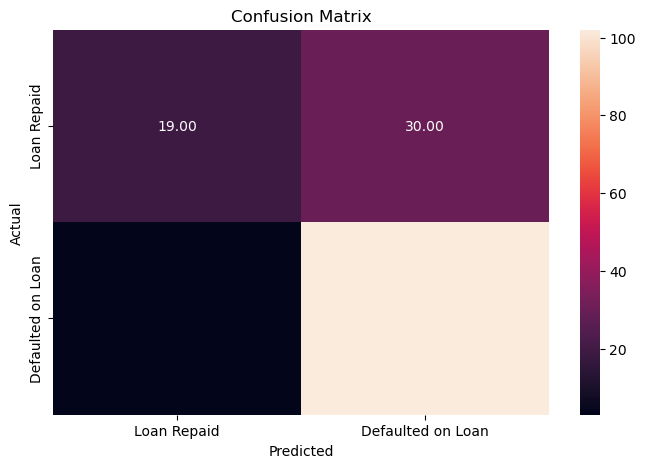

In [44]:
# Checking performance on the test dataset
y_test_pred_decision_tree = decision_tree.predict(X_test)

classification_metrics(y_test, y_test_pred_decision_tree)

The precision, recall, and F1-score of the "Loan Repaid" class are comparatively good, suggesting that the model does a decent job of correctly categorizing occurrences of "Loan Repaid." But the precision, recall, and F1-score of the "Defaulted on Loan" class are lower, indicating that the model is less successful in detecting occurrences of "Defaulted on Loan." This suggests that there may be an imbalance or difficulty in categorizing examples that fall within the "Defaulted on Loan" class.

## Random Forest

In [45]:
# Fitting the random forest tree classifier on the training data
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth = 100,n_estimators = 500, random_state = 1)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=500, random_state=1)

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.79      0.45      0.57        49
Defaulted on Loan       0.79      0.94      0.86       105

         accuracy                           0.79       154
        macro avg       0.79      0.70      0.71       154
     weighted avg       0.79      0.79      0.77       154



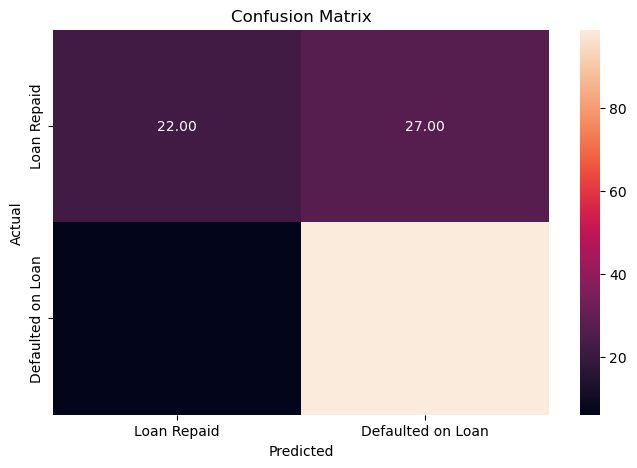

In [46]:
# Checking performance on the testing data
y_pred_test_rf = rf_model.predict(X_test)

classification_metrics(y_test, y_pred_test_rf)

The Random Forest model demonstrates good generalization performance on the test data, 

## Naive Bayes

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.78      0.43      0.55        49
Defaulted on Loan       0.78      0.94      0.85       105

         accuracy                           0.78       154
        macro avg       0.78      0.69      0.70       154
     weighted avg       0.78      0.78      0.76       154



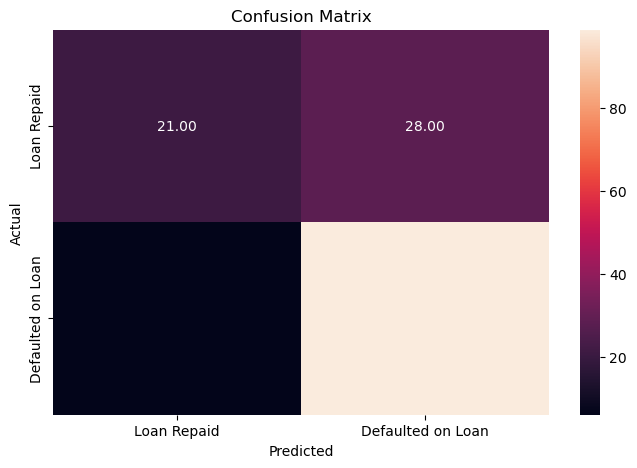

In [47]:
#Using NaiveBayes Model
from sklearn.naive_bayes import GaussianNB
naive_model = GaussianNB()
naive_model.fit(X_train,y_train)
model_predict = naive_model.predict(X_test)
classification_metrics(y_test, model_predict)

## Gradient Boosting

Classification Report:
                    precision    recall  f1-score   support

      Loan Repaid       0.66      0.47      0.55        49
Defaulted on Loan       0.78      0.89      0.83       105

         accuracy                           0.75       154
        macro avg       0.72      0.68      0.69       154
     weighted avg       0.74      0.75      0.74       154



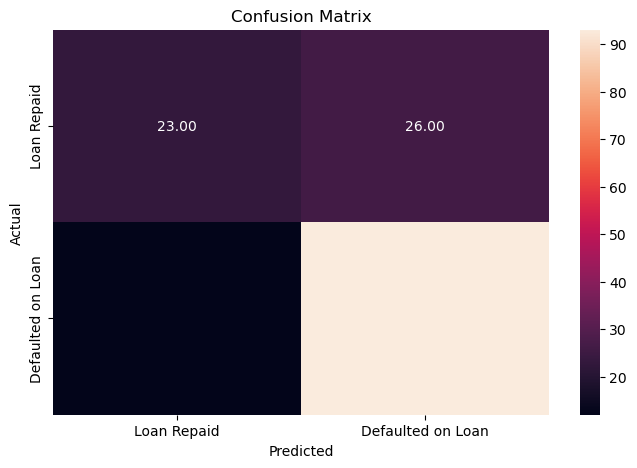

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
gboost_clf = GradientBoostingClassifier(n_estimators=500,max_depth=10)
gboost_clf.fit(X_train,y_train)
gboost_pred = gboost_clf.predict(X_test)
classification_metrics(y_test, gboost_pred)

In [49]:
# Create a dictionary of models
models = {
    'logistic_model': logistic_model,
    'decision_tree': decision_tree,
    'rf_model': rf_model,
    'naive_model': naive_model,
    'gboost_clf': gboost_clf
    
}

# Create an empty list to store the results
results = []

# Iterate through the models and compute the performance metrics
for model_name, model in models.items():  # Use .items() to iterate through both keys and values
    metrics = model_performance_classification(model, X_test, y_test)
    results.append({'Model': model_name, **metrics})

# Create a DataFrame from the results
comparing_test_models_df = pd.DataFrame(results)

# Set the 'Model' column as the index
comparing_test_models_df.set_index('Model', inplace=True)

# Display the DataFrame
print(comparing_test_models_df)

                Precision  Recall  Accuracy
Model                                      
logistic_model       0.82    0.68      0.79
decision_tree        0.82    0.68      0.79
rf_model             0.79    0.70      0.79
naive_model          0.78    0.69      0.78
gboost_clf           0.72    0.68      0.75


 Comparison of various techniques and their relative performance based on chosen Metric
   
Various methods were used to address the classification issue. With an accuracy of 0.79, the logistic_model, decision_tree, and rf_model beat the others, demonstrating their overall accuracy in loan default prediction. The "decision_tree" model performed well, exhibiting balanced precision (0.82) and recall (0.68). But there is always room for improvement, particularly when it comes to recall and precision, which are crucial factors in loan default prediction. Even better outcomes could come from further feature engineering and a more complex model.

## Applicant Loan Input

In [50]:
dependents = int(input("Enter number of dependents: "))
loan_amount = float(input("Enter the loan amount:"))
credit_history = input("Enter credit history (good/bad): ")
income = float(input("Enter the annual income: "))
loan_status = input("Enter loan status (approved/rejected): ")
credit_score = int(input("Enter the credit score: "))

if dependents <= 0:
    print("You are a loan defaulter due to lack of dependents.")
elif loan_amount > 10000:
    print("You are a loan defaulter due to high loan amount.")
elif credit_history == "bad":
    print("You are a loan defaulter due to bad credit history.")    
if income < 50000 or credit_score < 600:
    print("The applicant is a loan defaulter.")
elif loan_status == "rejected":
    print("You are a loan defaulter due to loan rejection.")    
else:
    print("Congratulations! You are not a loan defaulter.")